In [51]:
from sklearn import preprocessing
from sklearn import metrics
from keras import Sequential
from keras import models
from sklearn import model_selection

In [52]:
import pandas as pd
df = pd.read_csv('/content/data.csv')
print(df.shape)
print(df.isnull().sum())

In [55]:
df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')>

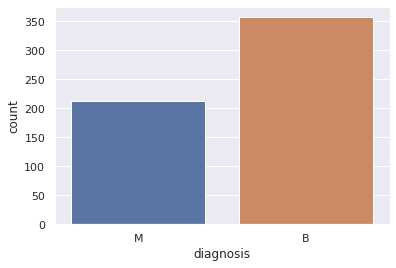

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.countplot(x='diagnosis', data=df)

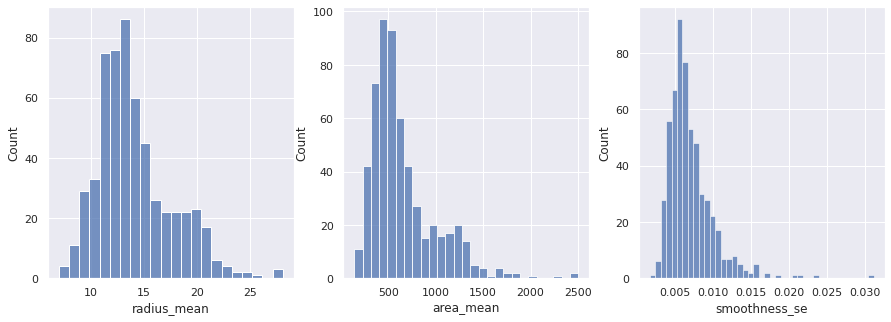

In [57]:
fig, ax =plt.subplots(1,3, figsize=(15, 5))
sns.histplot(df['radius_mean'], ax=ax[0])
sns.histplot(df['area_mean'], ax=ax[1])
sns.histplot(df['smoothness_se'], ax=ax[2])
fig.show()

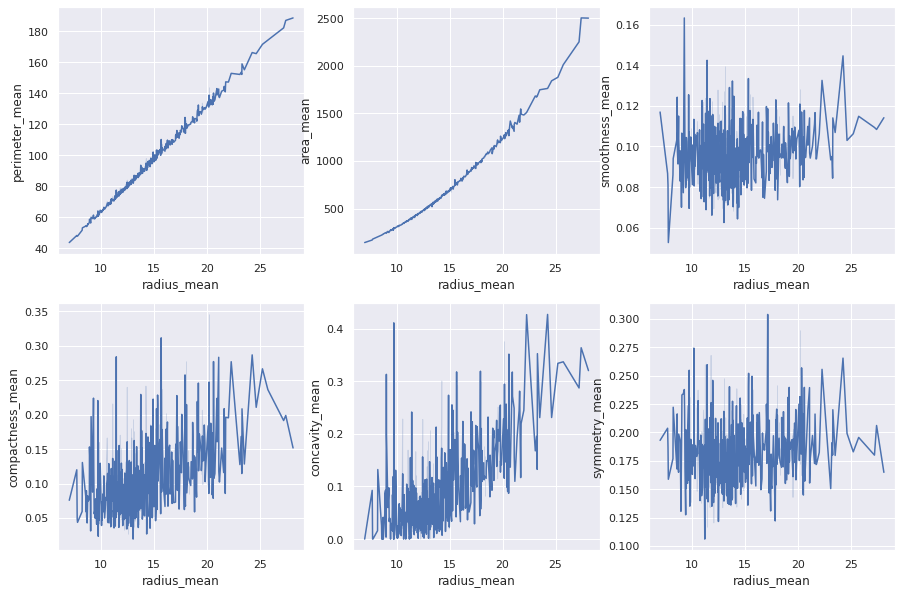

In [58]:
#Look for strong correlations so you can drop certain highly correlated features. 
fig, ax =plt.subplots(2,3, figsize=(15, 10))
sns.lineplot(x=df['radius_mean'], y=df['perimeter_mean'], ax=ax[0,0])
sns.lineplot(x=df['radius_mean'], y=df['area_mean'], ax=ax[0,1])
sns.lineplot(x=df['radius_mean'], y=df['smoothness_mean'], ax=ax[0,2])
sns.lineplot(x=df['radius_mean'], y=df['compactness_mean'], ax=ax[1,0])
sns.lineplot(x=df['radius_mean'], y=df['concavity_mean'], ax=ax[1,1])
sns.lineplot(x=df['radius_mean'], y=df['symmetry_mean'], ax=ax[1,2])
fig.show()

In [59]:
corr = df.corr()
corr_unstacked = corr.unstack()
corr_unstacked_sorted = corr_unstacked.sort_values(kind="quicksort", ascending=False)
corr_df=pd.Series.to_frame(corr_unstacked_sorted, name='correlation')  #Convert Series to DataFrame and name correlation column accordingly. 
high_corr_features =  corr_df[corr_df.correlation != 1]  #Remove all 1s that correspond to self correlation
print(high_corr_features.head(30)) 

                                 correlation
radius_mean     perimeter_mean      0.997855
perimeter_mean  radius_mean         0.997855
radius_worst    perimeter_worst     0.993708
perimeter_worst radius_worst        0.993708
area_mean       radius_mean         0.987357
radius_mean     area_mean           0.987357
area_mean       perimeter_mean      0.986507
perimeter_mean  area_mean           0.986507
area_worst      radius_worst        0.984015
radius_worst    area_worst          0.984015
area_worst      perimeter_worst     0.977578
perimeter_worst area_worst          0.977578
radius_se       perimeter_se        0.972794
perimeter_se    radius_se           0.972794
perimeter_mean  perimeter_worst     0.970387
perimeter_worst perimeter_mean      0.970387
radius_worst    radius_mean         0.969539
radius_mean     radius_worst        0.969539
perimeter_mean  radius_worst        0.969476
radius_worst    perimeter_mean      0.969476
perimeter_worst radius_mean         0.965137
radius_mea

In [60]:
#Drop features that are highly correlated with another feature. 
#In this case, let us just use Radius and drop area & perimeter.
cols = [c for c in df.columns if c.lower()[:4] != 'area']  #Drop all column names starting with 'area'
df=df[cols]  #Update the dataframe with new columns
cols = [c for c in df.columns if c.lower()[:9] != 'perimeter'] #Drop all column names starting with 'perimeter'
df=df[cols]  #Update the dataframe with new columns
print(df.columns)
print(df.shape)

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'concavity_mean', 'concave points_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
       'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se',
       'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst',
       'Unnamed: 32'],
      dtype='object')
(569, 27)


In [61]:
print(df.isnull().sum())
#df = df.dropna()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32                569
dtype: int64


In [62]:
import numpy as np
####### Replace categorical values with numbers########
print("Distribution of data: ", df['diagnosis'].value_counts())
#Define the dependent variable that needs to be predicted (labels)
y = df["diagnosis"].values
print("Labels before encoding are: ", np.unique(y))
# Encoding categorical data from text (B and M) to integers (0 and 1)
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(y) # M=1 and B=0
print("Labels after encoding are: ", np.unique(Y))

Distribution of data:  B    357
M    212
Name: diagnosis, dtype: int64
Labels before encoding are:  ['B' 'M']
Labels after encoding are:  [0 1]


In [63]:
#Define x and normalize / scale values
#Define the independent variables. Drop label and ID, and normalize other data
X = df.drop(labels = ["diagnosis", "id"], axis=1) 
print(X.describe().T) #Needs scaling

                         count       mean       std        min        25%  \
radius_mean              569.0  14.127292  3.524049   6.981000  11.700000   
texture_mean             569.0  19.289649  4.301036   9.710000  16.170000   
smoothness_mean          569.0   0.096360  0.014064   0.052630   0.086370   
compactness_mean         569.0   0.104341  0.052813   0.019380   0.064920   
concavity_mean           569.0   0.088799  0.079720   0.000000   0.029560   
concave points_mean      569.0   0.048919  0.038803   0.000000   0.020310   
symmetry_mean            569.0   0.181162  0.027414   0.106000   0.161900   
fractal_dimension_mean   569.0   0.062798  0.007060   0.049960   0.057700   
radius_se                569.0   0.405172  0.277313   0.111500   0.232400   
texture_se               569.0   1.216853  0.551648   0.360200   0.833900   
smoothness_se            569.0   0.007041  0.003003   0.001713   0.005169   
compactness_se           569.0   0.025478  0.017908   0.002252   0.013080   

In [64]:
#Scale / normalize the values to bring them to similar range
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)
X = np.nan_to_num(X)
print(X)  #Scaled values

[[0.52103744 0.0226581  0.59375282 ... 0.59846245 0.41886396 0.        ]
 [0.64314449 0.27257355 0.28987993 ... 0.23358959 0.22287813 0.        ]
 [0.60149557 0.3902604  0.51430893 ... 0.40370589 0.21343303 0.        ]
 ...
 [0.45525108 0.62123774 0.28816467 ... 0.12872068 0.1519087  0.        ]
 [0.64456434 0.66351031 0.58833619 ... 0.49714173 0.45231536 0.        ]
 [0.03686876 0.50152181 0.         ... 0.25744136 0.10068215 0.        ]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [65]:
# 3. Get data ready for training: Reshape data and define X_train, X_test, X_val, y_train, y_test, y_val, define augmentation
#Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print("Shape of training data is: ", X_train.shape)
print("Shape of testing data is: ", X_test.shape)

Shape of training data is:  (426, 25)
Shape of testing data is:  (143, 25)


In [66]:
# 4. Define the model: How many layers, appropriate activation functions, do you need to add dropout, appropriate optimizer, loss, metrics, use transfer learning?
import tensorflow as tf
opt1 = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
opt2 = tf.keras.optimizers.Adam(learning_rate=0.1)

In [67]:
from keras.layers import Dense, Dropout, Activation
model = Sequential()
model.add(Dense(16, input_dim=25, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, input_dim=25, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
loss= tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer=opt1, metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 16)                416       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
 activation_4 (Activation)   (None, 1)                 0         
                                                                 
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [68]:
# **5. Train the model:** Ensure enough validation data for good accuracy checks during training.
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
#from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
#Overwrite the model each time accuracy improves. Saves a lot of space. 
#filepath="/content/drive/MyDrive/Colab Notebooks/saved_models/best_model.hdf5" #File name includes epoch and validation accuracy.
#early_stop = EarlyStopping(filepath, monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
#callbacks_list = [early_stop]

In [75]:
#Fit with early stopping (and other) callback. 
history = model.fit(X_train, y_train, verbose=1, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0874 - accuracy: 0.9742 - val_loss: 0.0634 - val_accuracy: 0.9860
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0858 - accuracy: 0.9718 - val_loss: 0.1174 - val_accuracy: 0.9580
Epoch 3/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0938 - accuracy: 0.9695 - val_loss: 0.0666 - val_accuracy: 0.9790
Epoch 4/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0740 - accuracy: 0.9765 - val_loss: 0.0750 - val_accuracy: 0.9720
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0828 - accuracy: 0.9765 - val_loss: 0.0740 - val_accuracy: 0.9720
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0660 - accuracy: 0.9765 - val_loss: 0.0607 - val_accuracy: 0.9650
Epoch 7/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0686 - accuracy: 0.9789 - val_loss: 0.0622 - val_accuracy: 0.9720
Epoch 8/50
7/7 [===========

**6. Re-train, if necessary:** Check accuracy on test data, understand learning curves and continue training the model, if needed.

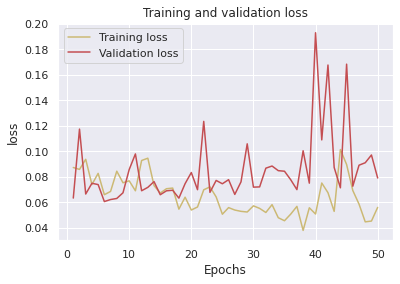

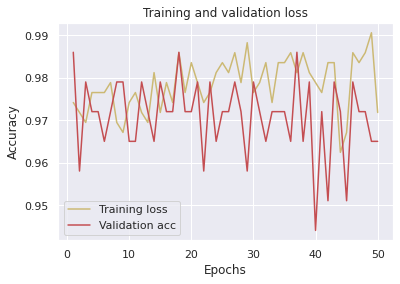

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'y', label='Training loss')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

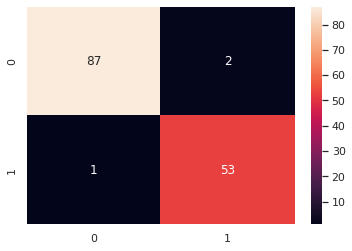

In [71]:
ypred = model.predict(X_test)
ypred = (ypred > 0.5)
cm = metrics.confusion_matrix(y_test, ypred)
sns.heatmap(cm, annot=True) 

In [72]:
eval = model.evaluate(X_test, ypred)
print(X_test[:2]) 
print(ypred[:2])

5/5 [==============================] - 0s 3ms/step - loss: 0.0412 - accuracy: 1.0000
[[0.25978513 0.30064254 0.42448316 0.26507576 0.18755858 0.18991054
  0.43686869 0.29001685 0.10305993 0.1511227  0.17812829 0.12661099
  0.06820707 0.19643872 0.1398379  0.09297569 0.25044468 0.33635394
  0.4717031  0.20423786 0.21333866 0.34879725 0.2856298  0.2129083
  0.        ]
 [0.56599934 0.39228948 0.33817821 0.2561806  0.25304592 0.39517893
  0.26363636 0.09793597 0.24526525 0.09664516 0.09283747 0.10715895
  0.05729798 0.25951885 0.08411662 0.02774899 0.60227677 0.3880597
  0.31783662 0.20016299 0.21461661 0.61477663 0.19436231 0.07116621
  0.        ]]
[[False]
 [ True]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


In [73]:
# 7. Save the model for future use:
# model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial106.h5')

In [74]:
# 8. Load model (in future) and use it to predict:
# Here, let us apply the loaded model to predict on our test data. 
#from keras.models import load_model
#my_loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial106.h5')
#y_pred_loaded_model = my_loaded_model.predict(X_test)
#y_pred_loaded_model = (y_pred_loaded_model > 0.5)

# Making the Confusion Matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred_loaded_model)

#sns.heatmap(cm, annot=True)